Starting the experiment...
--- Running for alpha = 0.0 ---
  Outlier value = 0.0
  Outlier value = 5.0
  Outlier value = 10.0
  Outlier value = 15.0
  Outlier value = 20.0
  Outlier value = 25.0
  Outlier value = 30.0
  Outlier value = 35.0
  Outlier value = 40.0
  Outlier value = 45.0
  Outlier value = 50.0
  Outlier value = 55.0
  Outlier value = 60.0
  Outlier value = 65.0
  Outlier value = 70.0
  Outlier value = 75.0
  Outlier value = 80.0
  Outlier value = 85.0
  Outlier value = 90.0
  Outlier value = 95.0
  Outlier value = 100.0
--- Running for alpha = 0.5 ---
  Outlier value = 0.0
  Outlier value = 5.0
  Outlier value = 10.0
  Outlier value = 15.0
  Outlier value = 20.0
  Outlier value = 25.0
  Outlier value = 30.0
  Outlier value = 35.0
  Outlier value = 40.0
  Outlier value = 45.0
  Outlier value = 50.0
  Outlier value = 55.0
  Outlier value = 60.0
  Outlier value = 65.0
  Outlier value = 70.0
  Outlier value = 75.0
  Outlier value = 80.0
  Outlier value = 85.0
  Outlier value

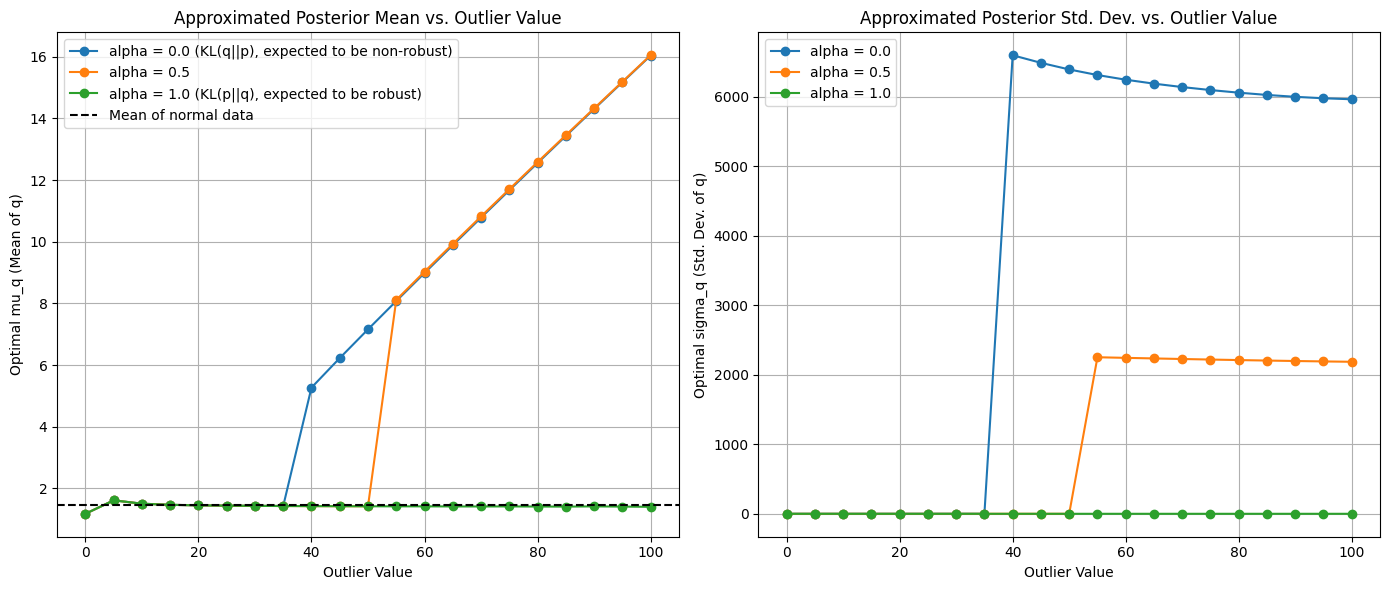

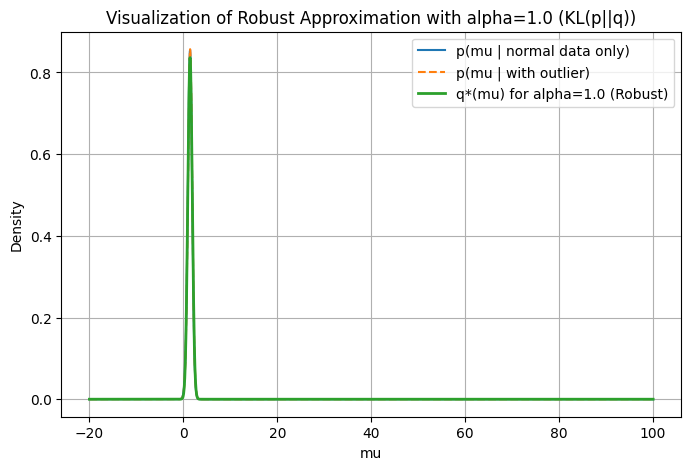

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as student_t

# --- 1. Model and Data Configuration ---
# Generate data
np.random.seed(0)
true_mu = 0.0
normal_data = np.random.randn(5) + true_mu
# The outlier value will be varied in a loop later.

# Prior distribution p(mu)
prior_mean = 0.0
prior_std = 2.0

# Parameters for the likelihood p(y|mu) (Student-t)
likelihood_df = 3  # Degrees of freedom (nu), which determines the tail heaviness
likelihood_scale = 1.0

# --- 2. Posterior Distribution and Alpha-Divergence Setup ---

# Function to calculate the true posterior on a grid
def calculate_true_posterior(data, mu_grid):
    # Log of the prior distribution
    log_prior = -0.5 * ((mu_grid - prior_mean) / prior_std)**2
    
    # Log of the likelihood
    log_likelihood = torch.zeros_like(mu_grid)
    for y in data:
        # Log probability density function of the Student-t distribution
        log_likelihood += torch.from_numpy(
            student_t.logpdf(y - mu_grid.numpy(), df=likelihood_df, scale=likelihood_scale)
        )
        
    # Log of the unnormalized posterior
    log_unnormalized_posterior = log_prior + log_likelihood
    
    # Exponentiate and normalize
    unnormalized_posterior = torch.exp(log_unnormalized_posterior - torch.max(log_unnormalized_posterior))
    posterior = unnormalized_posterior / torch.trapz(unnormalized_posterior, mu_grid)
    
    return posterior

# Function to calculate Alpha-divergence D_alpha(p || q)
def alpha_divergence(p, q, alpha, mu_grid):
    # Small epsilon for numerical stability
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    
    if alpha == 1.0: # Forward KL divergence KL(p || q)
        integrand = p * (torch.log(p) - torch.log(q))
    elif alpha == 0.0: # Reverse KL divergence KL(q || p)
        integrand = q * (torch.log(q) - torch.log(p))
    else:
        integrand = (p**alpha * q**(1-alpha) - alpha * p - (1-alpha) * q) / (alpha * (alpha - 1))
        
    return torch.trapz(integrand, mu_grid)

# --- 3. Variational Inference Execution ---

def run_variational_inference(data, alpha, mu_grid):
    # Define the parameters of q(mu) = N(mu|mu_q, sigma_q) and mark them for optimization
    mu_q = torch.tensor([np.mean(data)], requires_grad=True)
    # Since sigma_q must be positive, we optimize it in log-space
    log_sigma_q = torch.tensor([np.log(np.std(data))], requires_grad=True)
    
    optimizer = torch.optim.Adam([mu_q, log_sigma_q], lr=0.1)
    
    # Calculate the true posterior p
    p_posterior = calculate_true_posterior(data, mu_grid)
    
    for i in range(200):
        optimizer.zero_grad()
        
        # Calculate the current q
        sigma_q = torch.exp(log_sigma_q)
        q_distribution = torch.distributions.Normal(mu_q, sigma_q)
        q_posterior = torch.exp(q_distribution.log_prob(mu_grid))
        
        # Calculate the objective function (Alpha-divergence)
        loss = alpha_divergence(p_posterior, q_posterior, alpha, mu_grid)
        
        # Calculate gradients and update parameters
        loss.backward()
        optimizer.step()
        
    return mu_q.item(), torch.exp(log_sigma_q).item()

# --- 4. Experiment Execution and Plotting ---

# Define the computation range for mu
mu_grid = torch.linspace(-20, 100, 2000)

# Alpha values to test
alphas_to_test = [0.0, 0.5, 1.0] 

# Vary the value of the outlier
outlier_values = np.linspace(0, 100, 21)

results = {alpha: {'mu_q': [], 'sigma_q': []} for alpha in alphas_to_test}

print("Starting the experiment...")
for alpha in alphas_to_test:
    print(f"--- Running for alpha = {alpha} ---")
    for outlier_val in outlier_values:
        print(f"  Outlier value = {outlier_val:.1f}")
        current_data = np.append(normal_data, outlier_val)
        
        # Run Variational Inference
        opt_mu_q, opt_sigma_q = run_variational_inference(current_data, alpha, mu_grid)
        
        # Store the results
        results[alpha]['mu_q'].append(opt_mu_q)
        results[alpha]['sigma_q'].append(opt_sigma_q)
print("Experiment finished.")

# --- Plotting the Results ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the mean mu_q
for alpha in alphas_to_test:
    label = f'alpha = {alpha}'
    if alpha == 1.0:
        label += ' (KL(p||q), expected to be robust)' # Note: This is KL(p||q) not KL(q||p), which is the standard notation for this objective.
    if alpha == 0.0:
        label += ' (KL(q||p), expected to be non-robust)'
    ax1.plot(outlier_values, results[alpha]['mu_q'], 'o-', label=label)

ax1.set_xlabel('Outlier Value')
ax1.set_ylabel('Optimal mu_q (Mean of q)')
ax1.set_title('Approximated Posterior Mean vs. Outlier Value')
ax1.grid(True)
ax1.axhline(np.mean(normal_data), color='k', linestyle='--', label='Mean of normal data')
ax1.legend()

# Plot for the standard deviation sigma_q
for alpha in alphas_to_test:
    label = f'alpha = {alpha}'
    ax2.plot(outlier_values, results[alpha]['sigma_q'], 'o-', label=label)

ax2.set_xlabel('Outlier Value')
ax2.set_ylabel('Optimal sigma_q (Std. Dev. of q)')
ax2.set_title('Approximated Posterior Std. Dev. vs. Outlier Value')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Visualize the posterior shift for alpha=1.0 (for reference)
plt.figure(figsize=(8, 5))
data_no_outlier = normal_data
data_with_outlier = np.append(normal_data, 50) # Example with outlier = 50
p_no_outlier = calculate_true_posterior(data_no_outlier, mu_grid)
p_with_outlier = calculate_true_posterior(data_with_outlier, mu_grid)
mu_q_opt, sigma_q_opt = run_variational_inference(data_with_outlier, 1.0, mu_grid)
q_opt_dist = torch.distributions.Normal(mu_q_opt, sigma_q_opt)
q_opt = torch.exp(q_opt_dist.log_prob(mu_grid))

plt.plot(mu_grid.numpy(), p_no_outlier.numpy(), label='p(mu | normal data only)')
plt.plot(mu_grid.numpy(), p_with_outlier.numpy(), label='p(mu | with outlier)', linestyle='--')
plt.plot(mu_grid.numpy(), q_opt.numpy(), label='q*(mu) for alpha=1.0 (Robust)', linewidth=2)
plt.title('Visualization of Robust Approximation with alpha=1.0 (KL(p||q))')
plt.xlabel('mu')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()